In [1]:
import os
import json
import matplotlib.pyplot as plt

import xarray as xr
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
from pypalettes import load_cmap
cmap = load_cmap("highcontrast")

In [3]:
path = '/home/users/cturrell/documents/eddy_feedback/chapter1/cmip6/data/100y/cmip6_daily_efp_winters_100y.csv'

df = pd.read_csv(path)
df

,model,efp_nh,efp_nh_gt3,efp_nh_123,efp_sh,efp_sh_gt3,efp_sh_123
0,AWI-ESM-1-1-LR,0.1758,0.1019,0.0572,0.2034,0.1682,0.0291
1,CMCC-CM2-SR5,0.2909,0.1378,0.1450,0.1241,0.1365,0.0302
2,CMCC-ESM2,0.2358,0.0995,0.1304,0.2104,0.1714,0.0415
3,CanESM5-1,0.2806,0.1549,0.0977,0.2757,0.2409,0.0379
4,EC-Earth3,0.1948,0.0818,0.0952,0.1708,0.0924,0.0150
5,EC-Earth3-CC,0.2057,0.0719,0.1144,0.1348,0.0887,0.0272
6,EC-Earth3-LR,0.2140,0.0956,0.1012,0.1232,0.0743,0.0109
7,EC-Earth3-Veg,0.1781,0.0657,0.1220,0.1341,0.0931,0.0178
8,EC-Earth3-Veg-LR,0.2415,0.0939,0.1133,0.1976,0.1583,0.0224
9,IPSL-CM5A2-INCA,0.2228,0.1144,0.0877,0.2844,0.2164,0.0229


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from pypalettes import load_cmap

# Load custom colormap
cmap = load_cmap("highcontrast")
palette = cmap.colors


/home/users/cturrell/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


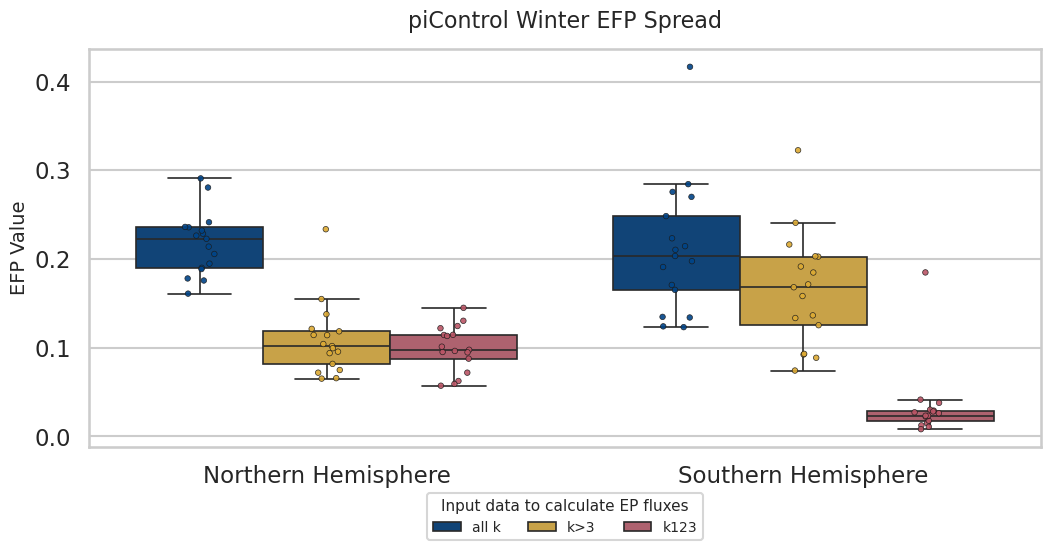

In [5]:

# Convert to discrete palette for seaborn
# palette = sns.color_palette(cmap, n_colors=3)

# Melt to long format for seaborn
df_long = df.melt(
    id_vars="model",
    value_vars=["efp_nh", "efp_nh_gt3", "efp_nh_123", "efp_sh", "efp_sh_gt3", "efp_sh_123"],
    var_name="hemisphere_dataset", value_name="efp"
)

# Split hemisphere and dataset info
df_long[['hemisphere', 'dataset']] = df_long['hemisphere_dataset'].str.extract(r'efp_(nh|sh)(_.*)?')
df_long['dataset'] = df_long['dataset'].replace({None: 'all k', '_gt3': 'k>3', '_123': 'k123'})

# Set general style and context (no palette override)
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(11, 6))

# Boxplot
sns.boxplot(
    data=df_long,
    x='hemisphere', y='efp', hue='dataset',
    linewidth=1.2, showfliers=False,
    palette=palette
)

# Overlay stripplot
sns.stripplot(
    data=df_long,
    x='hemisphere', y='efp', hue='dataset',
    dodge=True, alpha=0.9, size=4, jitter=True,
    marker="o", linewidth=0.5, edgecolor='k',
    palette=palette
)

# Labels and title
plt.xlabel("")
plt.ylabel("EFP Value", fontsize=14)
plt.title("piControl Winter EFP Spread", fontsize=16, pad=15)
plt.xticks([0, 1], ["Northern Hemisphere", "Southern Hemisphere"])

# Remove duplicate legend handles
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3],
           title="Input data to calculate EP fluxes", loc="lower center",
           bbox_to_anchor=(0.5, -0.25),
           ncol=3, fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

---

# Reanalysis error bars

In [6]:
import pandas as pd
import numpy as np
import os

bootstrap_data = '/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/reanalysis/1979_2016'
files = os.listdir(bootstrap_data)

# Create empty lists to store data
efp_types = []
efp_means = []
efp_stds = []

for file in files:
    
    data = np.load(os.path.join(bootstrap_data, file))
    
    # skip daily files
    time_freq = file.split('_')[1]
    if time_freq == 'daily':
        continue
    
    hemisphere = file.split('_')[-2]
    if hemisphere == 'djf-jra55':
        hemis = 'nh'
    else:
        hemis = 'sh'
    
    # split up into desired spatial scales
    which_k = file.split('_')[4]
    if which_k == '123':
        column = f'EFP_{hemis}_k123'
        data_mean = np.mean(data, axis=0)
        data_std = np.std(data, axis=0)
    elif which_k == 'gt3':
        column = f'EFP_{hemis}_k>3'
        data_mean = np.mean(data, axis=0)
        data_std = np.std(data, axis=0)
    else:
        column = f'EFP_{hemis}_total'
        data_mean = np.mean(data, axis=0)
        data_std = np.std(data, axis=0)
    
    # Append data to lists
    efp_types.append(column)
    efp_means.append(data_mean)
    efp_stds.append(data_std)
    
    print(file)
    print(column,':', data_mean, f'[{data_mean - data_std:.3f}, {data_mean + data_std:.3f}]')

# Create pandas DataFrame
bootstrap_df = pd.DataFrame({
    'efp_type': efp_types,
    'efp_mean': efp_means,
    'efp_std': efp_stds
})

bootstrap_df

FileNotFoundError: [Errno 2] No such file or directory: '/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/reanalysis/1979_2016'

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


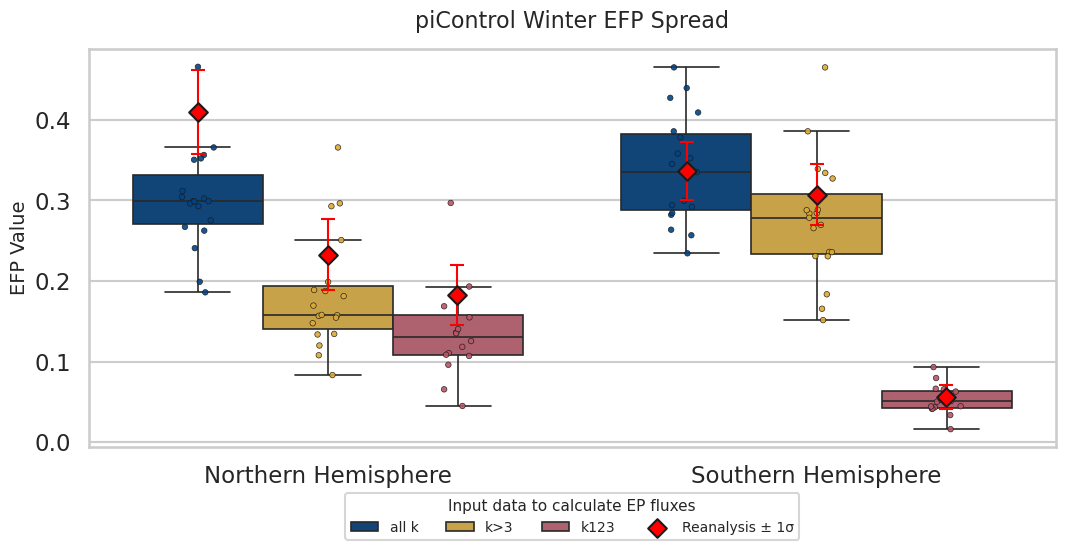

In [ ]:
# Convert to discrete palette for seaborn
# palette = sns.color_palette(cmap, n_colors=3)

# Melt to long format for seaborn
df_long = df.melt(
    id_vars="model",
    value_vars=["efp_nh", "efp_nh_gt3", "efp_nh_123", "efp_sh", "efp_sh_gt3", "efp_sh_123"],
    var_name="hemisphere_dataset", value_name="efp"
)

# Split hemisphere and dataset info
df_long[['hemisphere', 'dataset']] = df_long['hemisphere_dataset'].str.extract(r'efp_(nh|sh)(_.*)?')
df_long['dataset'] = df_long['dataset'].replace({None: 'all k', '_gt3': 'k>3', '_123': 'k123'})

# Set general style and context (no palette override)
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(11, 6))

# Boxplot
sns.boxplot(
    data=df_long,
    x='hemisphere', y='efp', hue='dataset',
    linewidth=1.2, showfliers=False,
    palette=palette
)

# Overlay stripplot
sns.stripplot(
    data=df_long,
    x='hemisphere', y='efp', hue='dataset',
    dodge=True, alpha=0.9, size=4, jitter=True,
    marker="o", linewidth=0.5, edgecolor='k',
    palette=palette
)

# --- Add custom points with error bars ---
# Assuming you have a DataFrame called 'bootstrap_df' with columns: efp_type, efp_mean, efp_std
points = {
    ("NH", "total"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_total']['efp_mean'].values[0],
    ("NH", "k>3"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_k>3']['efp_mean'].values[0],
    ("NH", "k123"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_k123']['efp_mean'].values[0],
    ("SH", "total"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_total']['efp_mean'].values[0],
    ("SH", "k>3"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_k>3']['efp_mean'].values[0],
    ("SH", "k123"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_k123']['efp_mean'].values[0],
}

# Get standard deviations for error bars
errors = {
    ("NH", "total"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_total']['efp_std'].values[0],
    ("NH", "k>3"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_k>3']['efp_std'].values[0],
    ("NH", "k123"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_nh_k123']['efp_std'].values[0],
    ("SH", "total"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_total']['efp_std'].values[0],
    ("SH", "k>3"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_k>3']['efp_std'].values[0],
    ("SH", "k123"): bootstrap_df[bootstrap_df['efp_type'] == 'EFP_sh_k123']['efp_std'].values[0],
}

ax = plt.gca()

positions = {
    ("NH", "total"): -0.265,
    ("NH", "k>3"):  0.0,
    ("NH", "k123"):  0.265,
    ("SH", "total"):  0.735,
    ("SH", "k>3"):  1.0,
    ("SH", "k123"):  1.265,
}

for (hemi, dataset), value in points.items():
    x = positions[(hemi, dataset)]
    error = errors[(hemi, dataset)]
    
    # Add error bars
    ax.errorbar(x, value, yerr=error, color='red', capsize=5, capthick=1.5, 
                elinewidth=1.5, zorder=9)
    
    # Add point
    ax.scatter(x, value, color='red', s=90, edgecolor='k', zorder=10, marker='D')

# Labels and title
plt.xlabel("")
plt.ylabel("EFP Value", fontsize=14)
plt.title("piControl Winter EFP Spread", fontsize=16, pad=15)
plt.xticks([0, 1], ["Northern Hemisphere", "Southern Hemisphere"])

# Remove duplicate legend handles and add reanalysis
handles, labels = plt.gca().get_legend_handles_labels()

# Get the first 3 handles for the datasets
unique_handles = handles[0:3]
unique_labels = labels[0:3]

# Add proxy handle for the red diamonds with error bars
diamond_handle = plt.scatter([], [], color='red', edgecolor='k', marker='D', s=90, label='Reanalysis ± 1σ')
unique_handles.append(diamond_handle)
unique_labels.append('Reanalysis ± 1σ')

plt.legend(unique_handles, unique_labels,
           title="Input data to calculate EP fluxes", loc="lower center",
           bbox_to_anchor=(0.5, -0.25),
           ncol=4, fontsize=10, title_fontsize=11)

plt.tight_layout()


plt.savefig('/home/links/ct715/eddy_feedback/chapter1/cmip6/plots/cmip6_bw_30y.png', dpi=300)
plt.show()